In [67]:
import pandas as pd
import tweepy
import numpy as np
import config
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import datetime

In [2]:
analyzer =SentimentIntensityAnalyzer()

auth = tweepy.OAuthHandler(config.consumer_key, config.consumer_secret)
auth.set_access_token(config.access_token, config.access_token_secret)
api=tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [3]:
#Select Twitter users to analyze.
target_users =["@BBCNews", "@CBSNews", "@CNN", "@FoxNews", "@nytimes"]
network_df = pd.DataFrame()

In [4]:
#Run VADER sentiment analyer on 100 tweets for each user
compound = []
timestamp = []
pos = []
neu= []
neg = []
source = []
tweets_ago = []
text = []

for target in target_users:
    public_tweets = api.user_timeline(target, count=100)
    counter = 0
    
    for tweet in public_tweets:
        sentiment_result = analyzer.polarity_scores(tweet["text"])
        compound.append(sentiment_result['compound'])
        pos.append(sentiment_result["pos"])
        neu.append(sentiment_result["neu"])
        neg.append(sentiment_result["neg"])        
        timestamp.append(tweet['created_at'])
        source.append(tweet['user']['screen_name'])
        text.append(tweet['text'])
        tweets_ago.append(counter)
        
        counter 
        
#create DataFrame
network_df = pd.DataFrame({"Time":timestamp,
                           "Source":source,
                           "Text": text,
                           "Compound": compound,
                           "Positive": pos,
                           "Neutral":neu,
                           "Negative": neg, 
                           "Tweets Ago":tweets_ago,
                           })
        

In [49]:
#convert values in DataFrame
converted_timestamps = []
for raw_time in timestamp:
    converted_time = datetime.strptime(raw_time, "%a %b %d %H:%M:%S %z %Y")
    converted_timestamps.append(converted_time)
network_df.Time=converted_timestamps

network_df["Tweets Ago"] = -1 * network_df["Tweets Ago"]

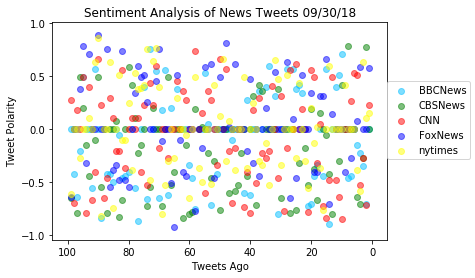

In [75]:
color = ["deepskyblue", "green", "red", "blue", "yellow"]
fig, ax = plt.subplots()

for i in range(len(target_users)):
    range_start = i*100
    range_end = i*100 + 99
    plt.scatter(x=network_df["Tweets Ago"].iloc[range_start:range_end], 
                y=network_df["Compound"].iloc[range_start:range_end], 
                c = color[i],
                alpha = .5,
                label = network_df["Source"].iloc[range_start])
fig.legend(bbox_to_anchor=(1.1, .7))
ax.set_xticklabels(["120", "100", "80", "60", "40", "20", "0"])
plt.yticks(np.arange(-1, 1.5, step=0.5))
plt.xlabel("Tweets Ago")
plt.ylabel("Tweet Polarity")
day = network_df["Time"][0].strftime("%m/%d/%y")
plt.title(f"Sentiment Analysis of News Tweets {day}")

fig.savefig("NewsNetworkSentiment.png", bbox_inches = "tight")

#### The compound sentiment score for many tweets is not uniformly distributed in the neighborhood of 0; tweets are more likely to have a polarity of exactly 0 rather than .1 or -.1.  

In [90]:
#Calculate avg polarity for each network over past 100 tweets
network_polarity = []

for i in range(len(target_users)):
    range_start = i*100
    range_end = i*100 + 99
    avg_polarity = network_df["Compound"].iloc[range_start:range_end].mean()
    network_polarity.append(avg_polarity)

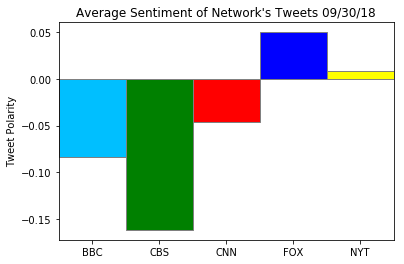

In [102]:
for j in range(len(target_users)):
    plt.bar(j+1, network_polarity[j], color = color[j], width = 1, edgecolor = "gray")
plt.xlim(.5, 5.5)
plt.xticks(np.arange(1, 6), ("BBC", "CBS", "CNN", "FOX", "NYT"))
plt.ylabel("Tweet Polarity")
plt.title(f"Average Sentiment of Network's Tweets {day}")
fig.savefig("AverageNetworkSentiment.png")

#### News networks post more negative tweets than positive tweets. 

In [112]:
#Calculate std deviation for network's tweets
polarity_std = []

for k in range(len(target_users)):
    range_start = k*100
    range_end = k*100 + 99
    std_dev = network_df["Compound"].iloc[range_start:range_end].std()
    polarity_std.append(round(std_dev, 2))
    
print(polarity_std)

[0.41, 0.39, 0.42, 0.4, 0.39]


#### The standard deviation of each network's tweets is very similar to the others'. Then, one network does not have a wider range of tweet polarities, or a narrower range of tweet polarities compared to the other networks. Based on the graph of polarity distribution and average polarity, it does not seem like any network has mostly negative or mostly positive tweets.